In [15]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [16]:
from sklearn.datasets import load_digits
digits = load_digits()

In [17]:
# normalize data
data = digits.data / 16

In [18]:
# split train / test set
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data, digits.target, test_size=0.1, random_state=1)

In [19]:
# take the transpose
train_X = train_X.T
test_X = test_X.T

# one hot encoder
train_y_ohe = np.zeros((10, train_y.shape[0]))
for count, y in enumerate(train_y):
    train_y_ohe[y][count] = 1

In [20]:
train_X.shape, train_y_ohe.shape

((64, 1617), (10, 1617))

In [21]:
def initialize_parameters(layer_dims): 
    parameters = {}
    for l in range(1, len(layer_dims)): 
        bound = np.sqrt(2/layer_dims[l-1])
        parameters['W' + str(l)] = np.random.uniform(-bound, bound, (layer_dims[l], layer_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

In [22]:
def linear_forward(A, W, b): 
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

def relu_activation(Z): 
    return np.maximum(0, Z)

def softmax_activation(Z):
    exp = np.exp(Z)
    return exp / exp.sum(axis=0)

def forward_propagation(X, parameters): 
    """ (LINEAR -> RELU) * (L-1) -> LINEAR -> SOFTMAX """ 

    L = len(parameters) // 2
    caches = [] 
    A = X 
    for l in range(1, L): 
        A_prev = A
        Z, linear_cache = linear_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)])
        A = relu_activation(Z)
        cache = (linear_cache, Z)
        caches.append(cache)

    ZL, linear_cache = linear_forward(A, parameters['W' + str(L)], parameters['b' + str(L)])
    AL = softmax_activation(ZL)
    cache = (linear_cache, ZL)
    caches.append(cache)

    return AL, caches

In [23]:
def compute_cost(AL, y): 
    y_hat = np.clip(AL, 0.00001, 0.99999)
    loss = - np.sum(y * np.log(y_hat), axis=0)
    cost = np.squeeze(np.mean(loss))
    return cost

In [24]:
def relu_activation_backward(dA, Z): 
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    
    return dZ

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

def backward_propagation(AL, Y, caches): 

    grads = {}
    L = len(caches) 

    dZL = AL - Y
    linear_cache, ZL = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(dZL, linear_cache)

    for l in reversed(range(1, L)):
        linear_cache, Z = caches[l-1]
        dZ = relu_activation_backward(grads["dA" + str(l)], Z)
        grads["dA" + str(l-1)], grads["dW" + str(l)], grads["db" + str(l)] = linear_backward(dZ, linear_cache)

    return grads

In [25]:
def update_parameters(parameters, grads, learning_rate): 
    L = len(parameters) // 2
    
    for l in range(1, L+1): 
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
    
    return parameters

In [26]:
def L_layer_model(X, Y, layers_dimensions, num_iterations, learning_rate=0.1, print_cost=False): 

    costs = []

    # initialize model
    parameters = initialize_parameters(layers_dimensions)

    for i in range(0, num_iterations):
        # forward propagation
        AL, caches = forward_propagation(X, parameters)

        # compute cost
        cost = compute_cost(AL, Y)

        # backward propatation
        grads = backward_propagation(AL, Y, caches)

        # updata parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # print and save cost value
        if print_cost and i % 100 == 0: 
            print ("Cost after iteration %i: %f" %(i, cost))
        costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 2.305918
Cost after iteration 100: 1.574029
Cost after iteration 200: 0.591246
Cost after iteration 300: 0.337468
Cost after iteration 400: 0.226270
Cost after iteration 500: 0.171168
Cost after iteration 600: 0.139858
Cost after iteration 700: 0.118618
Cost after iteration 800: 0.102696
Cost after iteration 900: 0.090169
Cost after iteration 1000: 0.079967
Cost after iteration 1100: 0.071556
Cost after iteration 1200: 0.064495
Cost after iteration 1300: 0.058501
Cost after iteration 1400: 0.053361
Cost after iteration 1500: 0.048814
Cost after iteration 1600: 0.044773
Cost after iteration 1700: 0.041179
Cost after iteration 1800: 0.037994
Cost after iteration 1900: 0.035130


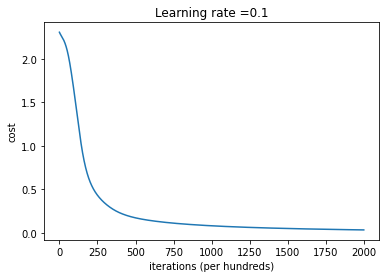

In [27]:
np.random.seed(1)

layers_dimensions = [64, 16, 16, 10]

parameters = L_layer_model(train_X, train_y_ohe, layers_dimensions, num_iterations=2000, learning_rate=0.1, print_cost=True)

In [28]:
def predict(X, parameters): 
    AL, caches = forward_propagation(X, parameters)
    return np.argmax(AL, axis=0)

In [38]:
from sklearn.metrics import accuracy_score
y_hat = predict(test_X, parameters)
accuracy_score(test_y, y_hat)

0.9611111111111111